In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")

from math import e, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
data = pd.DataFrame(data=iris.data, columns=iris.feature_names)
data['class'] = iris.target
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [7]:
data['class'].unique()

array([0, 1, 2], dtype=int64)

In [14]:
data.shape

(150, 5)

Логистическая регрессия для двух классов

In [325]:
class LogisticRegression:
    def __init__(self, alpha=0.01, n_iter=1000, threshold=0.5, l2=0.01, intercept=False):
        self.alpha = alpha
        self.l2 = l2
        self.threshold = threshold

        self.n_iter = n_iter
        self.intercept = intercept

    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        precision = 0.001

        if len(X.shape) == 1:
            m, n = X.shape[0], 1
        else:
            m, n = X.shape

        self.theta = np.full((n,), 0.33)
        for j in range(self.n_iter):
            theta_old = tuple(self.theta)

            y_hypoth = X.dot(self.theta)
            p = e ** y_hypoth / (e ** y_hypoth + 1)

            self.grad = X.T.dot(p - y) / m
            penalty = 2 * self.l2 * self.theta
            if self.intercept:
                penalty[0] = 0
            self.grad += penalty

#             check, J_plus, J_minus, diff = self.gradient_check(X, y)
#             if not check:
#                 print('gradient is incorrect!')
#                 print(J_plus, J_minus, diff)
#                 return

            self.theta -= self.alpha * self.grad

            precise = True
            for i in range(n):
                if abs(theta_old[i] - self.theta[i]) > precision:
                    precise = False
                    break
            if precise:
                print('iteration', str(j) + ': precise enough')
                break

    def predict(self, X_test):
        y_hypoth = X_test.dot(self.theta)
        p = e ** y_hypoth / (e ** y_hypoth + 1)

        get_predictions = lambda x: 1 if x > self.threshold else 0
        return pd.Series(np.vectorize(get_predictions)(p)), p

    def gradient_check(self, X, y):
        X, y = np.array(X), np.array(y)
        if len(X.shape) == 1:
            m, n = X.shape[0], 1
        else:
            m, n = X.shape[0], X.shape[1]

        epsilon = 10e-7

        for j in range(len(self.grad)):
            vector = np.full((n,), 0)
            vector[j] = 1

            theta_plus = self.theta + vector * epsilon
            y_hypoth_plus = X.dot(theta_plus)
            p_plus = e ** y_hypoth_plus / (e ** y_hypoth_plus + 1)
            J_plus = - sum(y * np.log(p_plus) + (1 - y) * np.log(1 - p_plus)) / m + self.l2 * sum(theta_plus ** 2)

            theta_minus = self.theta - vector * epsilon
            y_hypoth_minus = X.dot(theta_minus)
            p_minus = e ** y_hypoth_minus / (e ** y_hypoth_minus + 1)
            J_minus = - sum(y * np.log(p_minus) + (1 - y) * np.log(1 - p_minus)) / m + self.l2 * sum(theta_minus ** 2)

            diff = abs((J_plus - J_minus) / (2 * epsilon) - self.grad[j])
            if diff > epsilon:
                return False, J_plus, J_minus, diff

        return True, J_plus, J_minus, diff

Логистическая регрессия для двух классов с использованием Mini-batch

In [3]:
class MiniBatchLR:
    def __init__(self, alpha=0.01, epochs=100, batch_size=10, threshold=0.5, l2=0.01, intercept=False):
        self.alpha = alpha
        self.l2 = l2
        self.threshold = threshold

        self.epochs = epochs
        self.batch_size = batch_size
        self.intercept = intercept

    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        precision = 0.001

        if len(X.shape) == 1:
            m, n = X.shape[0], 1
        else:
            m, n = X.shape

        self.theta = np.full((n,), 0.33)
        for j in range(self.epochs):
            theta_old = tuple(self.theta)

            for k in range(0, m, self.batch_size):
                start = k
                size = min(self.batch_size, m - k)
                stop = k + size
#                 print('start =', start, ' stop =', stop)

                X_batch = X[start:stop]
                y_batch = y[start:stop]

                y_hypoth = X_batch.dot(self.theta)
                p = e ** y_hypoth / (e ** y_hypoth + 1)

                self.grad = X_batch.T.dot(p - y_batch) / size
                penalty = 2 * self.l2 * self.theta

                if self.intercept:
                    penalty[0] = 0
                self.grad += penalty
                self.theta -= self.alpha * self.grad

            precise = True
            for i in range(n):
                if abs(theta_old[i] - self.theta[i]) > precision:
                    precise = False
                    break
            if precise:
                print('epoch', str(j) + ': precise enough')
                break

    def predict(self, X_test):
        y_hypoth = X_test.dot(self.theta)
        p = e ** y_hypoth / (e ** y_hypoth + 1)

        get_predictions = lambda x: 1 if x > self.threshold else 0
        return pd.Series(np.vectorize(get_predictions)(p)), p

Метрики качества модели для двух классов

In [4]:
def precision(y_hypoth, y):
    y_hypoth, y = np.array(y_hypoth), np.array(y)
    tp = ((y_hypoth == y) & (y == 1)).sum()
    fp = ((y == 0) & (y_hypoth == 1)).sum()
    return tp / (tp + fp)

In [5]:
def recall(y_hypoth, y):
    y_hypoth, y = np.array(y_hypoth), np.array(y)
    tp = ((y_hypoth == y) & (y == 1)).sum()
    fn = ((y_hypoth == 0) & (y == 1)).sum()
    return tp / (tp + fn)

In [6]:
def f_measure(y_hypoth, y):
    pr, rec = precision(y_hypoth, y), recall(y_hypoth, y)
    return 2 * pr * rec / (pr + rec)

Нормализация данных

In [7]:
def min_max(X):
    if len(X.shape) == 1:
        X = [(x - min(X)) / (max(X) - min(X)) for x in X]
        return
    
    for col in X.columns:
        if max(X[col]) == min(X[col]):
            X[col] = 1
        else:
            X[col] = [(x - min(X[col])) / (max(X[col]) - min(X[col])) for x in X[col]]

Обучение на данных про ирисы (классы 0 и 1)

In [15]:
X, y = data.drop('class', axis=1), data['class']

In [16]:
X_two_class, y_two_class = data[data['class'] <= 1].drop('class', axis=1), data[data['class'] <= 1]['class']

In [17]:
poly = PolynomialFeatures(2, include_bias=True)
X_two_class_poly = pd.DataFrame(data = poly.fit_transform(X_two_class), columns=poly.get_feature_names(X_two_class.columns))
X_two_class_poly.head()

,1,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),sepal length (cm)^2,sepal length (cm) sepal width (cm),sepal length (cm) petal length (cm),sepal length (cm) petal width (cm),sepal width (cm)^2,sepal width (cm) petal length (cm),sepal width (cm) petal width (cm),petal length (cm)^2,petal length (cm) petal width (cm),petal width (cm)^2
0,1.0,5.1,3.5,1.4,0.2,26.01,17.85,7.14,1.02,12.25,4.90,0.70,1.96,0.28,0.04
1,1.0,4.9,3.0,1.4,0.2,24.01,14.70,6.86,0.98,9.00,4.20,0.60,1.96,0.28,0.04
2,1.0,4.7,3.2,1.3,0.2,22.09,15.04,6.11,0.94,10.24,4.16,0.64,1.69,0.26,0.04
3,1.0,4.6,3.1,1.5,0.2,21.16,14.26,6.90,0.92,9.61,4.65,0.62,2.25,0.30,0.04
4,1.0,5.0,3.6,1.4,0.2,25.00,18.00,7.00,1.00,12.96,5.04,0.72,1.96,0.28,0.04


In [18]:
min_max(X_two_class_poly)
min_max(y_two_class)

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X_two_class_poly, y_two_class, test_size=0.33, random_state=18)
# model = LogisticRegression(alpha=0.01, threshold=0.5, l2=0.01, intercept=True)

model = MiniBatchLR(alpha=0.01, epochs=10000, batch_size=10, threshold=0.5, l2=0.01, intercept=True)
%time model.fit(X_train, Y_train)

epoch 507: precise enough
Wall time: 360 ms


In [32]:
Y_hypoth, pred_proba = model.predict(X_test)
precision(Y_hypoth, Y_test), recall(Y_hypoth, Y_test), f_measure(Y_hypoth, Y_test)

(1.0, 1.0, 1.0)

In [33]:
model.theta

array([-1.52611646,  0.20739539, -0.8846714 ,  0.84175319,  0.84246498,
        0.23901378, -0.51966476,  0.75169732,  0.78547712, -0.77729013,
        0.58341294,  0.66333183,  0.83816077,  0.84164902,  0.75135035])

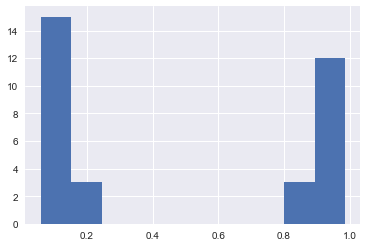

In [34]:
pred_proba.hist()

Логистическая регрессия для K классов

In [532]:
class SoftmaxRegression:
    def __init__(self, alpha=0.01, epochs=100, batch_size=10, threshold=0.5, l2=0.01, intercept=False):
        self.alpha = alpha
        self.l2 = l2
        self.threshold = threshold

        self.epochs = epochs
        self.batch_size = batch_size
        self.intercept = intercept

    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        precision = 0.001

        if len(X.shape) == 1:
            M, N = X.shape[0], 1
        else:
            M, N = X.shape
        K = pd.Series(y).nunique()

        self.theta = np.array([[0.33] * N for _ in range(K)])
        
        for epoch in range(self.epochs):
            if epoch % 10 == 0:
                print('epoch', epoch)
            
            theta_old = [tuple(self.theta[j]) for j in range(K)]

            for b in range(0, M, self.batch_size):
                start = b
                size = min(self.batch_size, M - b)
                stop = b + size

                X_batch = X[start:stop]
                y_batch = y[start:stop]

                y_hypoth = X_batch.dot(self.theta.T)
                p = e ** y_hypoth
                for i in range(size):
                    p[i] /= sum(e ** y_hypoth[i])

                self.grad = np.array([[0.0] * N for j in range(K)])
                for j in range(K):
                    for n in range(N):
                        for i in range(size):
                            if j == y_batch[i]:
                                self.grad[j][n] += (p[i][j] - 1.0) * X_batch[i][n]
                            else:
                                self.grad[j][n] += p[i][j] * X_batch[i][n]
                
                penalty = 2 * self.l2 * self.theta
                if self.intercept:
                    penalty[:, 0] = 0.0
                self.grad += penalty
                
                self.theta -= self.alpha * self.grad

            precise = True
            for j in range(K):
                for n in range(N):
                    if abs(theta_old[j][n] - self.theta[j][n]) > precision:
                        precise = False
                        break
            if precise:
                print('epoch', str(epoch) + ': precise enough')
                break

    def predict(self, X_test):
        X_test = np.array(X_test)
        
        y_hypoth = X_test.dot(self.theta.T)        
        p = e ** y_hypoth
        for i in range(len(X_test)):
            p[i] /= sum(e ** y_hypoth[i])
        
        predictions = [p[i].argmax() for i in range(len(X_test))]
        pred_proba = [max(p[i]) for i in range(len(X_test))]
        return pd.Series(predictions), pred_proba

Метрики качества модели для К классов

In [562]:
def metrics(y_hypoth, y_test):
    y_hypoth, y_test = np.array(y_hypoth), np.array(y_test)
    classes = pd.Series(y_test).unique()
    K = len(classes)
    
    confusion_matrix = [[0] * K for _ in range(K)]
    for i in range(K):
        for j in range(K):
            confusion_matrix[i][j] = ((y_test == i) & (y_hypoth == j)).sum()
    
    tp, fp, fn = np.full((K,), 0), np.full((K,), 0), np.full((K,), 0)
    for j in range(K):
        tp[j] = confusion_matrix[j][j]
        fp[j] = sum([confusion_matrix[i][j] for i in range(K)]) - tp[j]
        fn[j] = sum(confusion_matrix[j]) - tp[j]
    
    pr_micro = sum(tp) / sum(tp + fp)
    r_micro = sum(tp) / sum(tp + fn)
    f_micro = 2 * pr_micro * r_micro / (pr_micro + r_micro)
    
    pr_macro = sum(tp / (tp + fp)) / K
    r_macro = sum(tp / (tp + fn)) / K
    f_macro = 2 * pr_macro * r_macro / (pr_macro + r_macro)
    
    return f_micro, f_macro

Обучение на данных про ирисы 

In [511]:
X_poly = pd.DataFrame(data = poly.fit_transform(X), columns=poly.get_feature_names(X.columns))

In [ ]:
min_max(X_poly)
min_max(y)

In [512]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=18)
model = SoftmaxRegression(alpha=0.01, epochs=1000, batch_size=10, threshold=0.5, l2=0.01, intercept=True)
%time model.fit(X_train, Y_train)

epoch 397: precise enough
Wall time: 6.12 s


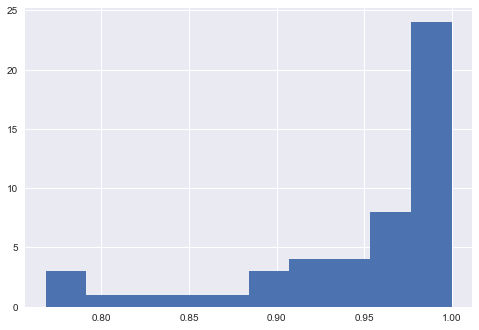

In [513]:
Y_hypoth, pred_proba = model.predict(X_test)
pd.Series(pred_proba).hist()

In [514]:
metrics(Y_hypoth, Y_test)

(0.98, 0.98080864542575)

Обучение на данных mnist/digits (распознавание рукописных цифр)

In [527]:
from sklearn.datasets import load_digits
mnist = load_digits()
data = pd.DataFrame(data=mnist.data)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [526]:
data['class'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [531]:
data.shape

(1797, 64)

In [529]:
X, y = data, pd.Series(mnist.target)

In [559]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=18)
model = SoftmaxRegression(alpha=0.01, epochs=100, batch_size=25, threshold=0.5, l2=0.1, intercept=True)
%time model.fit(X_train, Y_train)

epoch 0
epoch 10
epoch 20
epoch 30
epoch 40
epoch 50
epoch 60
epoch 70
epoch 80
epoch 90
Wall time: 10min 29s


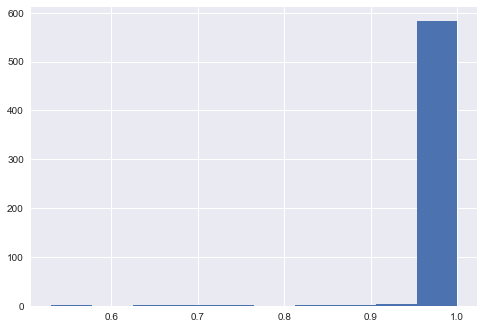

In [560]:
Y_hypoth, pred_proba = model.predict(X_test)
pd.Series(pred_proba).hist()

In [563]:
metrics(Y_hypoth, Y_test)

(0.9191919191919192, 0.927033927599065)